# Web Scraping solution


## Step 1: Install dependencies

In [1]:
pip install pandas requests lxml

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Download HTML

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import io

# Get the HTML
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
response = requests.get(url)

if response.status_code != 200:
    raise Exception(f"Error accessing the page: {response.status_code}")

# Check the response
print("Status:", response.status_code)

Status: 200


## Step 3: Transform the HTML

In [3]:
# Extract tables with pandas
html = io.StringIO(response.text)  # Convert the HTML to a text file

# read_html() returns a list of DataFrames
tables = pd.read_html(html)
print(f"{len(tables)} tables were found.")

27 tables were found.


In [4]:
# Inspect the first rows of the correct table
df = tables[0]  # Extract the first table from the 27 found
df.head()  # Display the first 5 rows

,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,4.913,29 November 2019,[2]
1,2,"""Shape of You""",Ed Sheeran,4.439,6 January 2017,[3]
2,3,"""Starboy""",The Weeknd and Daft Punk,3.973,21 September 2016,[4]
3,4,"""Someone You Loved""",Lewis Capaldi,3.961,8 November 2018,[5]
4,5,"""As It Was""",Harry Styles,3.952,1 April 2022,[6]


## Step 4: Process the DataFrame

In [5]:
# Data cleaning

# Rename columns if necessary
df.columns = ["Rank", "Song", "Artist", "Streams (billions)", "Date released", "Reference"]

df = df.copy()  # Create a copy of the DataFrame

# Remove notes in square brackets
df["Song"] = df["Song"].str.replace(r"\[.*?\]", "", regex=True)
df["Artist"] = df["Artist"].str.replace(r"\[.*?\]", "", regex=True)

# Filter rows containing a valid number in the "Streams (billions)" column
df = df[df["Streams (billions)"].astype(str).str.contains(r"^\d+(?:\.\d+)?$", na=False)].copy()

# Convert Streams to float numbers
df["Streams (billions)"] = df["Streams (billions)"].astype(float)

# Convert dates to datetime
df["Date released"] = pd.to_datetime(df["Date released"], errors="coerce")

df

,Rank,Song,Artist,Streams (billions),Date released,Reference
0,1,"""Blinding Lights""",The Weeknd,4.913,2019-11-29,[2]
1,2,"""Shape of You""",Ed Sheeran,4.439,2017-01-06,[3]
2,3,"""Starboy""",The Weeknd and Daft Punk,3.973,2016-09-21,[4]
3,4,"""Someone You Loved""",Lewis Capaldi,3.961,2018-11-08,[5]
4,5,"""As It Was""",Harry Styles,3.952,2022-04-01,[6]
...,...,...,...,...,...,...
95,96,"""New Rules""",Dua Lipa,2.353,2017-06-02,NaN
96,97,"""Someone Like You""",Adele,2.337,2011-01-24,[97]
97,98,"""Too Good At Goodbyes""",Sam Smith,2.331,2017-09-08,[98]
98,99,"""Stay with Me""",Sam Smith,2.322,2014-04-14,[99]


## Step 5: Store the data in sqlite

In [6]:
# Create the database
conn = sqlite3.connect("spotify_top_songs.db")

In [7]:
# Create table in SQLite
df.to_sql("most_streamed", conn, if_exists="replace", index=False)
cursor = conn.cursor()

In [8]:
# Insert data into the database
cursor.execute("SELECT COUNT(*) FROM most_streamed")
print("Rows inserted:", cursor.fetchone()[0])

conn.commit()
conn.close()

Rows inserted: 100


## Step 6: Visualize the data

### Visual Analysis of Popularity on Spotify

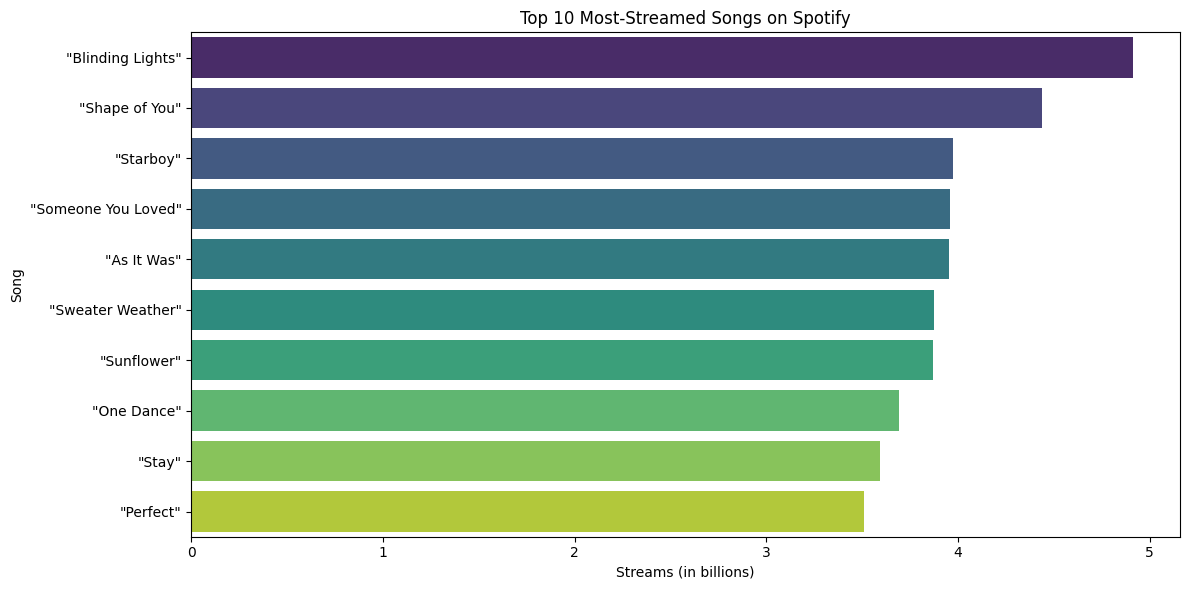

In [9]:
# Plot the data

# Chart 1: Top 10 most-streamed songs
top10 = df.nlargest(10, "Streams (billions)")
plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x="Streams (billions)", y="Song", hue="Song", palette="viridis", legend=False)
plt.title("Top 10 Most-Streamed Songs on Spotify")
plt.xlabel("Streams (in billions)")
plt.ylabel("Song")
plt.tight_layout()
plt.show()

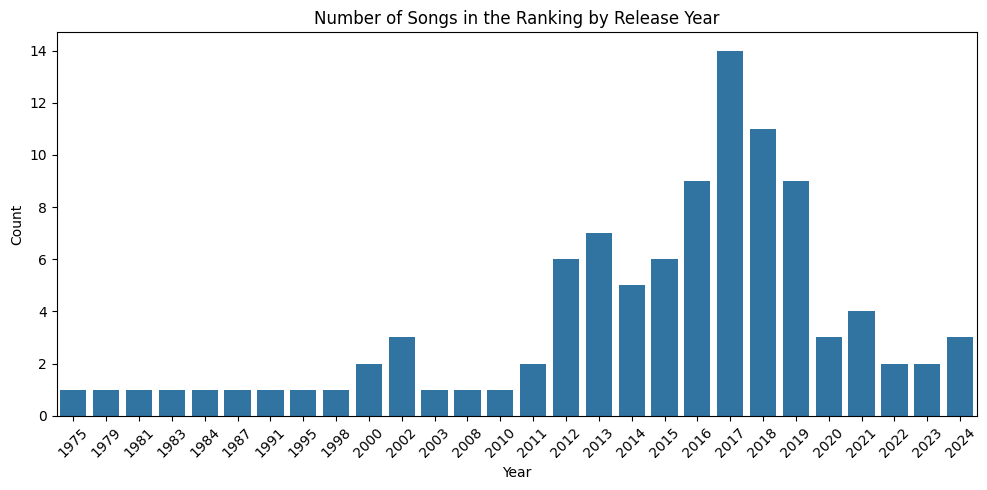

In [10]:
# Chart 2: Number of songs per year
df["Year"] = df["Date released"].dt.year
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Year", order=sorted(df["Year"].dropna().unique()))
plt.title("Number of Songs in the Ranking by Release Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

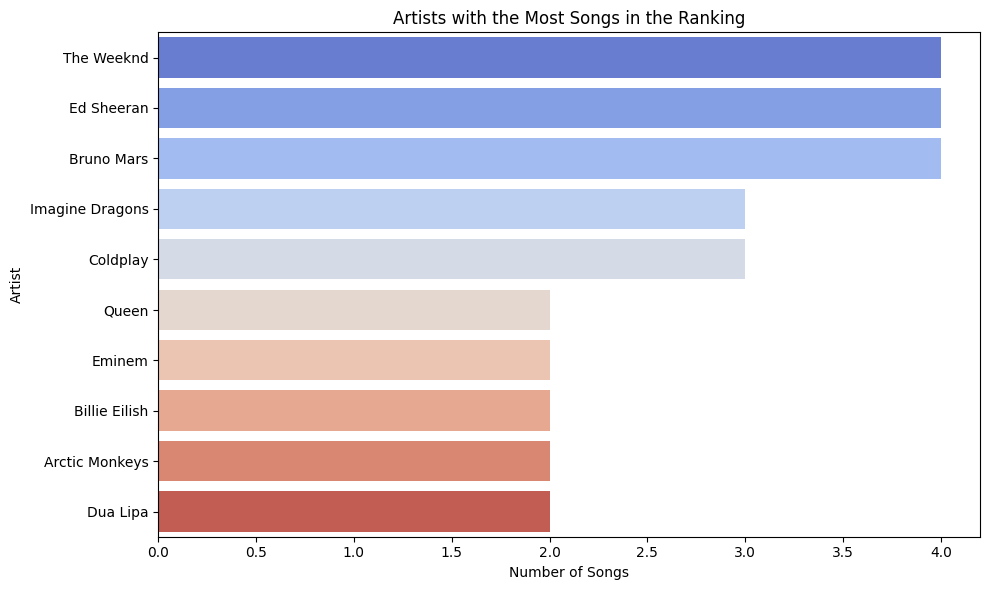

In [11]:
# Chart 3: Artists with the most songs in the ranking

# Note: Some artists have multiple songs
artists = df["Artist"].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=artists.values, y=artists.index, hue=artists.index, palette="coolwarm", legend=False)
plt.title("Artists with the Most Songs in the Ranking")
plt.xlabel("Number of Songs")
plt.ylabel("Artist")
plt.tight_layout()
plt.show()